In [2]:
#import relevant modules
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib notebook

#download data into DataFrame and create moving averages columns
df = data.DataReader('AAPL', 'yahoo', start='1/1/2014', end='1/1/2015')
#print out first 5 rows of data DataFrame to check in correct format
df.head()

C:\Users\s2007\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2013-12-31,80.182854,79.142860,79.167145,80.145714,55771100.0,71.756508
2014-01-02,79.575714,78.860001,79.382858,79.018570,58671200.0,70.747330
2014-01-03,79.099998,77.204285,78.980003,77.282860,98116900.0,69.193306
2014-01-06,78.114288,76.228569,76.778572,77.704285,103152700.0,69.570625
2014-01-07,77.994286,76.845711,77.760002,77.148575,79302300.0,69.073074


In [3]:
period=14
peroid_avg=3

In [4]:
#Create the "L14" column in the DataFrame
df['L'+str(period)] = df['Low'].rolling(window=period).min()

#Create the "H14" column in the DataFrame
df['H'+str(period)] = df['High'].rolling(window=period).max()

#Create the "%K" column in the DataFrame
df['%K'] = 100*((df['Close'] - df['L'+str(period)]) / (df['H'+str(period)] - df['L'+str(period)]) )

#Create the "%D" column in the DataFrame
df['%D'] = df['%K'].rolling(window=peroid_avg).mean()

df.tail()

,High,Low,Open,Close,Volume,Adj Close,L14,H14,%K,%D
Date,,,,,,,,,,
2014-12-24,112.709999,112.010002,112.580002,112.010002,14479600.0,102.395844,106.260002,116.080002,58.553973,59.006124
2014-12-26,114.519997,112.010002,112.099998,113.989998,33721000.0,104.205940,106.260002,114.849998,89.988347,68.648786
2014-12-29,114.769997,113.699997,113.790001,113.910004,27598900.0,104.132797,106.260002,114.849998,89.057099,79.199806
2014-12-30,113.919998,112.110001,113.639999,112.519997,29881500.0,102.862099,106.260002,114.849998,72.875404,83.973617
2014-12-31,113.129997,110.209999,112.820000,110.379997,41403400.0,100.905785,106.260002,114.769997,48.413605,70.115369


<IPython.core.display.Javascript object>


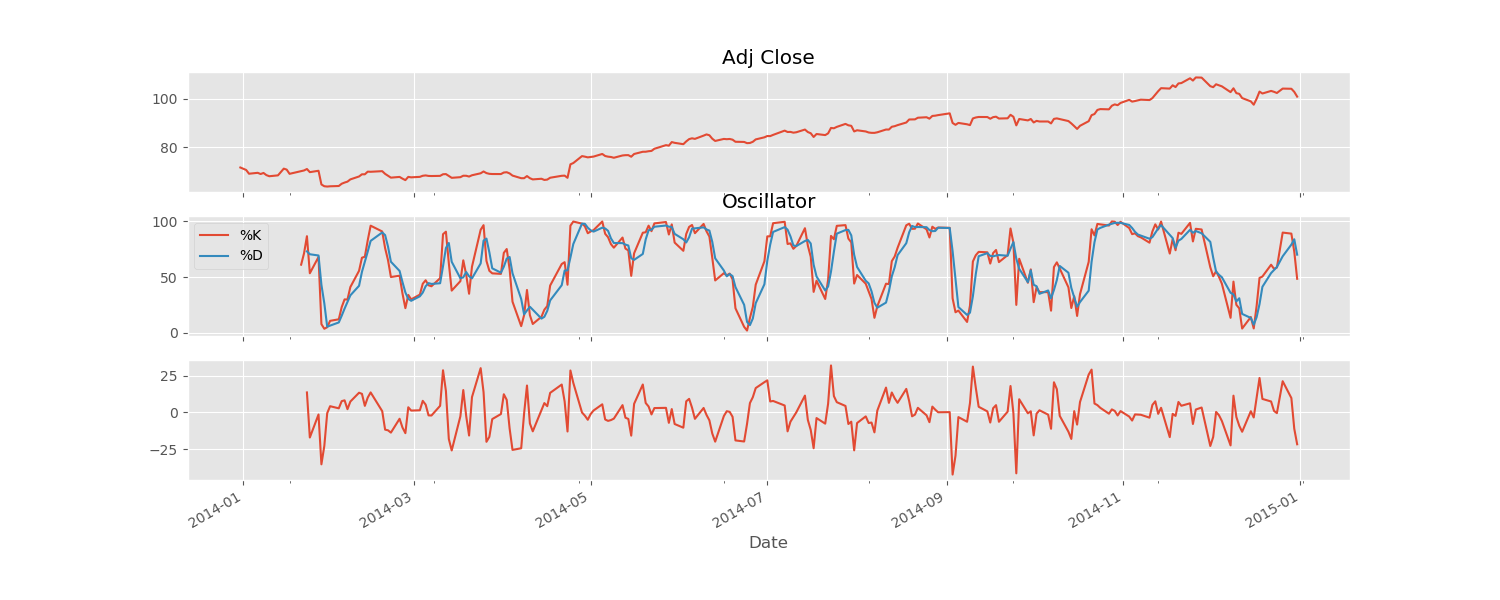

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(15,6),sharex=True)

df['Adj Close'].plot(ax=axes[0]); axes[0].set_title('Adj Close')
df[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator')
(df['%K'] - df['%D']).plot(ax=axes[2]); axes[2]
plt.show()

In [ ]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
df['Sell Entry'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80) 

#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
df['Sell Exit'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) 

#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
df['Short'] = np.nan
df.loc[df['Sell Entry'],'Short'] = -1 
df.loc[df['Sell Exit'],'Short'] = 0 

#Set initial position on day 1 to flat 
df['Short'][0] = 0 

#Forward fill the position column to represent the holding of positions through time 
df['Short'] = df['Short'].fillna(method='pad') 

In [ ]:
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
df['Buy Entry'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < 20) 

#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
df['Buy Exit'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) 

#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
df['Long'] = np.nan  
df.loc[df['Buy Entry'],'Long'] = 1  
df.loc[df['Buy Exit'],'Long'] = 0  

#Set initial position on day 1 to flat 
df['Long'][0] = 0  

#Forward fill the position column to represent the holding of positions through time 
df['Long'] = df['Long'].fillna(method='pad') 

In [ ]:
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
df['Position'] = df['Long'] #+ df['Short']

In [ ]:
df

In [ ]:
#df['Position'].plot(figsize=(20,10))
plt.figure(figsize=(12.2,4.5))
plt.plot(df.index, df['Position'])
plt.show()

In [ ]:
#Set up a column holding the daily Apple returns
df['Market Returns'] = df['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
#of business the previous day
df['Strategy Returns'] = df['Market Returns'] * df['Position'].shift(1)

#Finally plot the strategy returns versus Apple returns
df[['Strategy Returns','Market Returns']].cumsum().plot()